## Task 1 

You are provided with the [DBLP dataset](https://www.hse.ru/data/2016/05/17/1128901387/dblp.zip) or [HSE Dataset](https://drive.google.com/folderview?id=0BwBztFAl6eLOdGRhbW5DWElQY3c&usp=sharing) (warning, raw data!). It contains coauthorships that were revealed during $2000$-$2014$. Particularly, the file contains $3$ colomns: first two for authors' names and the third for the year of publication. This data can be naturally mapped to undirected graph structure.

Your task is construct supervised link prediction scheme.

### Guidelines:

0. Use *pandas* module to load and manipulate the dataset in Python
1. Initialize your classification set as follows:
    * Determine training and testing intervals on your time domain (for instance, in DBLP dataset take a period $2000$-$2010$ as training period and $2011$-$2014$ as testing period)
    * Pick pairs of authors that **have appeared during training interval** but **have not published together** (only for DBLP) during it
    * These pairs form **positive** or **negative** examples depending on whether they have formed coauthorships **during the testing interval**
    * You have arrived to binary classification problem. PROFIT!
2. Construct feature space:
    * Most of our features tend to be topological. Examples of the features can be: (weighted) sum of neigbours, shortest distance, etc
3. Choose at least $4$ classification algorithms from [scikit module](http://scikit-learn.org/stable/) (goes with Anaconda) and compare them in terms of Accuracy, Precision, Recall, F-Score (for positive class) and Mean Squared Error. Use k-fold cross-validation and average your results

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import combinations
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, 
                            mean_squared_error, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

sns.set_style("whitegrid")
%matplotlib inline

#### Load data.

In [2]:
url = 'https://www.dropbox.com/s/98ukvq82nz1swof/dblp_2000.csv?dl=1'
data = pd.read_csv(url, header = None, names = ['author_A', 'author_B', 'year'])

In [3]:
data.head()

,author_A,author_B,year
0,"""John N. Mordeson""","""Premchand S. Nair""",2000
1,"""Ernest Czogala""","""Jacek Leski""",2000
2,"""Rog\u00e9rio Lopes Salvini""","""Lu\u00eds Alfredo V. de Carvalho""",2000
3,"""Gustavo Luiz C. M. de Abreu""","""Rafael Lu\u00eds Teixeira""",2000
4,"""Gustavo Luiz C. M. de Abreu""","""Jos\u00e9 F. Ribeiro""",2000


In [4]:
print(data.shape[0])

9600228


There are too many pairs in the dataset (about 10M). It could lead to overly huge dataset at the classification stage (because all potential links will be in data for classification).  
Let's consider only 2011 - 2013 years for computational simplicity. These years also have roughly equal number of publications (around 1M).

In [10]:
data = data[(data.year >= 2011) & (data.year <= 2013)]

Function to process raw names data - remove tags and use lower case.

In [13]:
def process_name(name):
    no_tags = BeautifulSoup(name, 'lxml').get_text()  
    #letters_only = re.sub("[^a-zA-Z]", " ", no_tags)  
    name_clean = no_tags.lower()
    return name_clean
    #return(" ".join(name_clean))

Processing can take up to 15 min.

In [18]:
for row in range(data.shape[0]):
    data.author_A.iat[row] = process_name(data.author_A.iat[row])
    data.author_B.iat[row] = process_name(data.author_B.iat[row])
    # Show progress
    if row % 1000000 == 0:
        print ('Processed {} / {}'.format(row, data.shape[0]))

Processed 0 / 3223030
Processed 1000000 / 3223030
Processed 2000000 / 3223030
Processed 3000000 / 3223030


Find set of all unique names.

In [19]:
UniqAuthors = pd.concat([data.author_A, data.author_B]).unique()
print("There are {:0.0f} authors' names ".format(len(UniqAuthors)))

There are 623814 authors' names 


Make dictionary with names' ids - use them instead of strings.

In [20]:
AuthorsId = {}
i = 0
for author in UniqAuthors:
    if author in AuthorsId.keys(): continue
    AuthorsId[author] = i; i += 1

Replace names with ids.

In [22]:
for row in range(data.shape[0]):
    data.author_A.iat[row] = AuthorsId[data.author_A.iat[row]]
    data.author_B.iat[row] = AuthorsId[data.author_B.iat[row]]
    # Show progress
    if row % 1000000 == 0:
        print ('Processed {} / {}'.format(row, data.shape[0]))

Processed 0 / 3223030
Processed 1000000 / 3223030
Processed 2000000 / 3223030
Processed 3000000 / 3223030


Save the data to new file.

In [23]:
data.to_csv('DBLP_clean.csv')

We need 3 data splits for training and testing model:

* Data for feature generation, 2011
* Data for labeling links, 2012
* Data for model testing, 2013

In [24]:
FeaturesData = data[data.year == 2011]
LabelData = data[data.year == 2012]
TestData = data[data.year == 2013]

Create undirected graph from FeaturesData.

In [125]:
G = nx.Graph()
for row in range(FeaturesData.shape[0]):
    G.add_edge(FeaturesData.author_A.iat[row], FeaturesData.author_B.iat[row])
print("Graph is created! Number of edges - {}, number of nodes - {}".format(G.size(), len(G.nodes())))

Graph is created! Number of edges - 798664, number of nodes - 304968


There are still too many nodes in the network to make efficient computations on usual laptop.

I would prefer to take into account only those authors, who have large number of publications (famous authors). Let's say, we are interested in those authors, who have more than 50 publications.

In [126]:
print("{} nodes totally in Features Graph".format(len(G.nodes())))

# The nodes we are interested in.
NodesToLeave = [k for (k,v) in G.degree().items() if v >= 50]
NodesToRemove = set.difference(set(G.nodes()), set(NodesToLeave))
G.remove_nodes_from(NodesToRemove)

print("{} nodes are left finally in Features Graph".format(len(G.nodes())))

304968 nodes totally in Features Graph
979 nodes are left finally in Features Graph


In [154]:
coord = nx.spring_layout(G, k = 0.4)

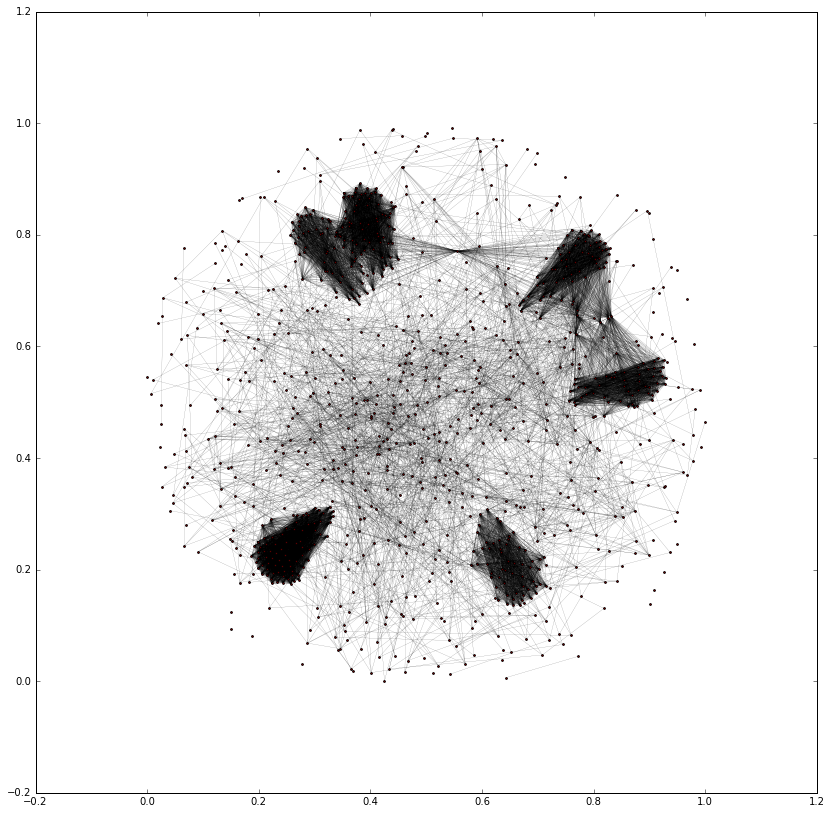

In [155]:
plt.figure(figsize=(14,14))
nx.draw_networkx(G, pos = coord, with_labels=False, node_size=3, width = 0.1)

Yes, the network looks frightening. There are 6 dense communities - ghosts.

Then add edges from the 2nd time step (2012), taking into account only those famous authors.

In [127]:
GG = G.copy()
for row in range(LabelData.shape[0]):
    GG.add_edge(LabelData.author_A.iat[row], LabelData.author_B.iat[row])

NodesToRemove = set.difference(set(GG.nodes()), set(NodesToLeave))
GG.remove_nodes_from(NodesToRemove)

print("Graph is created! Number of edges - {}, number of nodes - {}".format(GG.size(), len(GG.nodes())))

Graph is created! Number of edges - 14527, number of nodes - 979


Finally, let's create test network with all true links. 

In [128]:
GGG = GG.copy()
for row in range(TestData.shape[0]):
    GGG.add_edge(TestData.author_A.iat[row], TestData.author_B.iat[row])

NodesToRemove = set.difference(set(GGG.nodes()), set(NodesToLeave))
GGG.remove_nodes_from(NodesToRemove)

print("Graph is created! Number of edges - {}, number of nodes - {}".format(GGG.size(), len(GGG.nodes())))

Graph is created! Number of edges - 15646, number of nodes - 979


Save graphs to save time if they are needed in the future.

In [129]:
nx.write_gml(G, 'FeatureGraph.gml')
nx.write_gml(GG, 'FeatureLabelGraph.gml')
nx.write_gml(GGG, 'TestGraph.gml')

In [3]:
G = nx.read_gml('FeatureGraph.gml')
GG = nx.read_gml('FeatureLabelGraph.gml')
GGG = nx.read_gml('TestGraph.gml')

Find edges, which could potentially emerge at the 2nd time step (2012) and label them:

* +, if link has emerged
* -, otherwise

In [7]:
objects = list(set.difference(set(combinations(G.nodes(), 2)), set(G.edges())))
labels = []
EdgesNew = GG.edges()

# Loop over all potential links to label them 
for link in objects:
    # Pay attention to reversed order, as we have undirected graph.
    link_rev = (link[1], link[0])
    if (link not in EdgesNew) and (link_rev not in EdgesNew):
        # Zero, if the link has not emerged
        labels.append(0); continue
    labels.append(1)

In [8]:
DataTrain = pd.DataFrame(data = {'link': objects, 'label': labels})

The classes are highly unbalanced.

In [9]:
print('Share of positive labels:')
print('{:.2f}%'.format((DataTrain.label.sum() / DataTrain.shape[0]) * 100))

Share of positive labels:
0.91%


We have obtained train data (without features so far). Let's follow the same procedure to get test data.

In [10]:
objects = list(set.difference(set(combinations(GG.nodes(), 2)), set(GG.edges())))
labels = []
EdgesNew = GGG.edges()

for link in objects:
    link_rev = (link[1], link[0])
    if (link not in EdgesNew) and (link_rev not in EdgesNew):
        labels.append(0); continue
    labels.append(1)

DataTest = pd.DataFrame(data = {'link': objects, 'label': labels})

#### Feature construction.

Start with simple feature - number of common neighbors.

In [11]:
# Train Data
SeriesCommonNeigh = []
for i in range(DataTrain.shape[0]):
    link = DataTrain.link.iat[i]
    NumCommon = len(list(nx.common_neighbors(G, link[0], link[1])))
    SeriesCommonNeigh.append(NumCommon)
DataTrain['CommonNeigh'] = SeriesCommonNeigh

# Test Data
SeriesCommonNeigh = []
for i in range(DataTest.shape[0]):
    link = DataTest.link.iat[i]
    NumCommon = len(list(nx.common_neighbors(GG, link[0], link[1])))
    SeriesCommonNeigh.append(NumCommon)
DataTest['CommonNeigh'] = SeriesCommonNeigh

Jaccard coefficient might be also useful.

In [12]:
# Train Data
jaccard = nx.jaccard_coefficient(G, DataTrain.link.tolist())
SeriesJaccard = [j for (u,v,j) in list(jaccard)]
DataTrain['Jaccard'] = SeriesJaccard

# Test Data
jaccard = nx.jaccard_coefficient(GG, DataTest.link.tolist())
SeriesJaccard = [j for (u,v,j) in list(jaccard)]
DataTest['Jaccard'] = SeriesJaccard

Adamic-Adar index, which takes care of neighborhood sizes of common neighbors.

In [13]:
# Train Data
adamic = nx.adamic_adar_index(G, DataTrain.link.tolist())
SeriesAdamic = [a for (u,v,a) in list(adamic)]
DataTrain['AdamicAdar'] = SeriesAdamic

# Test Data
adamic = nx.adamic_adar_index(GG, DataTest.link.tolist())
SeriesAdamic = [a for (u,v,a) in list(adamic)]
DataTest['AdamicAdar'] = SeriesAdamic

Shortest path length.

In [14]:
# Train Data
SeriesShortestPath = []
for i in range(DataTrain.shape[0]):
    link = DataTrain.link.iat[i]
    try:
        ShortestPathLen = nx.shortest_path_length(G, link[0], link[1])
    except nx.NetworkXNoPath:
        ShortestPathLen = 1000
    SeriesShortestPath.append(ShortestPathLen)
DataTrain['ShortestPath'] = SeriesShortestPath

# Test Data
SeriesShortestPath = []
for i in range(DataTest.shape[0]):
    link = DataTest.link.iat[i]
    try:
        ShortestPathLen = nx.shortest_path_length(GG, link[0], link[1])
    except nx.NetworkXNoPath:
        ShortestPathLen = 1000
    SeriesShortestPath.append(ShortestPathLen)
DataTest['ShortestPath'] = SeriesShortestPath

Take into account preferential attachment possibility.

In [15]:
# Train Data
k = G.degree()
SeriesPrefAttach = []
for i in range(DataTrain.shape[0]):
    link = DataTrain.link.iat[i]
    k_1 = k[link[0]]
    k_2 = k[link[1]] 
    SeriesPrefAttach.append(k_1 + k_2)
DataTrain['PrefAttach'] = SeriesPrefAttach

# Test Data
k = GG.degree()
SeriesPrefAttach = []
for i in range(DataTest.shape[0]):
    link = DataTest.link.iat[i]
    k_1 = k[link[0]]
    k_2 = k[link[1]] 
    SeriesPrefAttach.append(k_1 + k_2)
DataTest['PrefAttach'] = SeriesPrefAttach

...and clustering coefficients.

In [16]:
# Train Data
cl = nx.clustering(G)
SeriesCluster = []
for i in range(DataTrain.shape[0]):
    link = DataTrain.link.iat[i]
    cl_1 = cl[link[0]]
    cl_2 = cl[link[1]] 
    SeriesCluster.append(cl_1 + cl_2)
DataTrain['Cluster'] = SeriesCluster

# Test Data
cl = nx.clustering(GG)
SeriesCluster = []
for i in range(DataTest.shape[0]):
    link = DataTest.link.iat[i]
    cl_1 = cl[link[0]]
    cl_2 = cl[link[1]] 
    SeriesCluster.append(cl_1 + cl_2)
DataTest['Cluster'] = SeriesCluster

Now, data has 5 features.

In [17]:
DataTrain.head()

,label,link,CommonNeigh,Jaccard,AdamicAdar,ShortestPath,PrefAttach,Cluster
0,0,"(13834, 58975)",0,0.000000,0.000000,6,23,0.764286
1,0,"(46386, 15606)",1,0.090909,0.417032,2,12,0.202381
2,0,"(141, 8770)",0,0.000000,0.000000,4,78,1.000000
3,0,"(120395, 163076)",0,0.000000,0.000000,3,69,1.803922
4,0,"(112527, 163085)",0,0.000000,0.000000,5,128,1.965309


#### Classification.

Now we are ready to move further into binary classification problem.

Firstle, take care of unbalanced classes.

In [20]:
# Upsampling
DataTrainExtra = DataTrain.copy()

while DataTrainExtra[DataTrainExtra.label == 1].shape[0] < DataTrainExtra[DataTrainExtra.label == 0].shape[0]:
    iDataExtra = resample(DataTrain[DataTrain.label == 1])
    DataTrainExtra = pd.concat([DataTrainExtra, iDataExtra])

In [21]:
# Train data:
X_train = DataTrainExtra.ix[:, 2:]
y_train = DataTrainExtra.ix[:, 0]

# Test data:
X_test = DataTest.ix[:, 2:]
y_test = DataTest.ix[:, 0]

First of all, let's look at KNN classifier.

In [22]:
# Function to print out results
def print_metrics(true, pred):
    print('Accuracy {:.4f}'.format(accuracy_score(true, pred)))
    print('Precision {:.4f}'.format(precision_score(true, pred)))
    print('Recall {:.4f}'.format(recall_score(true, pred)))
    print('F-score {:.4f}'.format(f1_score(true, pred)))
    print('MSE {:.4f}'.format(mean_squared_error(true, pred)))

In [23]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print_metrics(y_test, knn_pred)

Accuracy 0.9649
Precision 0.1746
Recall 0.7197
F-score 0.2810
MSE 0.0351


Logistic regression.

In [24]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print_metrics(y_test, lr_pred)

Accuracy 0.8407
Precision 0.0528
Recall 0.9281
F-score 0.0999
MSE 0.1593


Random Forest.

In [27]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print_metrics(y_test, rf_pred)

Accuracy 0.9768
Precision 0.2572
Recall 0.7633
F-score 0.3848
MSE 0.0232


XGBoost.

In [26]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc_pred = xgbc.predict(X_test)

print_metrics(y_test, xgbc_pred)

Accuracy 0.8401
Precision 0.0542
Recall 0.9607
F-score 0.1027
MSE 0.1599


**Conclusion.**

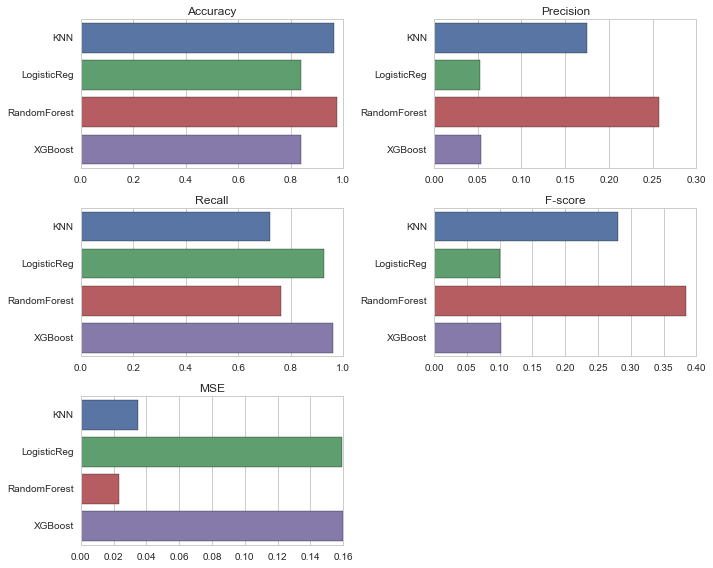

In [41]:
clfs = ['KNN', 'LogisticReg', 'RandomForest', 'XGBoost']
preds = [knn_pred, lr_pred, rf_pred, xgbc_pred]
x_accuracy = [accuracy_score(y_test, i) for i in preds]
x_precision = [precision_score(y_test, i) for i in preds]
x_recall = [recall_score(y_test, i) for i in preds]
x_f1 = [f1_score(y_test, i) for i in preds]
x_mse = [mean_squared_error(y_test, i) for i in preds]

plt.figure(figsize = (10, 8))
plt.subplot(3,2,1)
sns.barplot(x = x_accuracy, y = clfs)
plt.title('Accuracy')

plt.subplot(3,2,2)
sns.barplot(x = x_precision, y = clfs)
plt.title('Precision')

plt.subplot(3,2,3)
sns.barplot(x = x_recall, y = clfs)
plt.title('Recall')

plt.subplot(3,2,4)
sns.barplot(x = x_f1, y = clfs)
plt.title('F-score')

plt.subplot(3,2,5)
sns.barplot(x = x_mse, y = clfs)
plt.title('MSE')

plt.tight_layout()

We have 5 metrics, which can not be equally important. However, because the real task is unknown, one can not identify the most important metric.

If the goal is to find all the links (and not miss anyone), which will be set in the next time step - one should use recall metric. 

From the other hand, if the purpose is to make just right prediction, not taking into account how many links we have missed out - precision metric is more appropriate.

In this case F-1 score is recommended, which is trade-off between precision and recall, and its value is close to minimum of the two. 

* There is bias to good recall among all classifiers, so they are able to find almost all links, but their predictions often might be wrong (they predict link but the link will not appear).

* The best classifier in terms of F-score and accuracy is RandomForest

* There is no need to tune parameters, because overfitting can be easy (we have only one test split here).


## Task 2

Consider the [flickr dataset](https://www.hse.ru/data/2016/05/17/1128901463/flickr_data.tar.gz) (warning, raw data!). <br/>
File ''*users.txt*'' provides a table of form *userID*, *enterTimeStamp*, *additionalInfo*... <br/>
File "*contacts.txt*" consists of pairs of *userID*'s and link establishment timestamp <br/>

Recall *scoring functions* for link prediction. Your task is to compare the performance of each scoring function as follows:
1. TOP-$n$ accuracy
    * Denote the number of links $E_\text{new}$ appeared during testing period as $n$
    * Denote the ranked list of node pairs provided by score $s$ as $\hat{E}_s$
    * Take top-$n$ pairs from $\hat{E}_s$ and intersect it with $E_\text{new}$. Performance is measured as the size of resulted set
2. ROC and AUC ('star' subtask)

Essentially, for this task you also have to follow the guideline points $1$ and $2$ above. The only thing you have to keep in mind is that flickr dataset is growing dataset. Since then, consider nodes that are significantly represented both in training and testing intervals (for instance, have at least $5$ adjacent edges in training and testing intervals)

**Load data.**

In [2]:
url = 'https://www.dropbox.com/s/h7txt7th1pw787w/contacts.txt?dl=1'
data = pd.read_csv(url, sep = " ", header = None, names = ['user_1', 'user_2', 'time'])

In [3]:
data.head()

,user_1,user_2,time
0,41,42,29252304
1,41,44,24407893
2,41,46,28952340
3,41,48,59571678
4,41,51,24406619


Sort the dataframe by increasing time stamp values.

In [4]:
data.sort_values(by = 'time', inplace = True)
data_size = data.shape[0] 
print(data_size)

4641716


Let's take the first 2/3 of data as training set, the rest - test set.

In [5]:
TrainDataSize = int(2/3 * data_size)
TrainData = data.ix[:TrainDataSize, :]
TestData = data.ix[TrainDataSize + 1:, :]

Now, we can create graph for each time step.

In [20]:
# Train
G_train = nx.Graph()
for i in range(TrainData.shape[0]):
    G_train.add_edge(TrainData.user_1.iat[i], TrainData.user_2.iat[i])
    
# Test
G_test = G_train.copy()
for i in range(TestData.shape[0]):
    G_test.add_edge(TestData.user_1.iat[i], TestData.user_2.iat[i])    

Leave only significantly represented nodes.

In [21]:
# The nodes we are interested in.
NodesToLeave = [k for (k,v) in G_train.degree().items() if v >= 300]
NodesToRemove = set.difference(set(G_train.nodes()), set(NodesToLeave))
G_train.remove_nodes_from(NodesToRemove)
print("{} nodes are left finally in Train Graph".format(len(G_train.nodes())))

NodesToRemove = set.difference(set(G_test.nodes()), set(NodesToLeave))
G_test.remove_nodes_from(NodesToRemove)

1196 nodes are left finally in Train Graph


In [22]:
NewLinks = set.difference(set(G_test.edges()), set(G_train.edges()))

Extract all potential links.

In [23]:
PossibleLinks = set.difference(set(combinations(G_train.nodes(), 2)), set(G_train.edges()))
df = pd.DataFrame(data = {'link': list(PossibleLinks)})

**Scoring functions.**

Number of common neighbors.

In [24]:
SeriesCommonNeigh = []
for link in PossibleLinks:
    NumCommon = len(list(nx.common_neighbors(G_train, link[0], link[1])))
    SeriesCommonNeigh.append(NumCommon)
df['CommonNeigh'] = SeriesCommonNeigh

Jaccard coefficients.

In [25]:
jaccard = nx.jaccard_coefficient(G_train, df.link.tolist())
SeriesJaccard = [j for (u,v,j) in list(jaccard)]
df['Jaccard'] = SeriesJaccard

Adamic-Adar index

In [26]:
adamic = nx.adamic_adar_index(G_train, df.link.tolist())
SeriesAdamic = [a for (u,v,a) in list(adamic)]
df['AdamicAdar'] = SeriesAdamic

Shortest path length.

In [29]:
SeriesShortestPath = []
for link in PossibleLinks:
    try:
        ShortestPathLen = nx.shortest_path_length(G_train, link[0], link[1])
    except nx.NetworkXNoPath:
        ShortestPathLen = 1000
    SeriesShortestPath.append(ShortestPathLen)
df['ShortestPath'] = SeriesShortestPath

Preferential attachment.

In [36]:
k = G_train.degree()
SeriesPrefAttach = []
for link in PossibleLinks:
    k_1 = k[link[0]]
    k_2 = k[link[1]] 
    SeriesPrefAttach.append(k_1 + k_2)
df['PrefAttach'] = SeriesPrefAttach

Clustering coefficients.

In [37]:
cl = nx.clustering(G_train)
SeriesCluster = []
for link in PossibleLinks:
    cl_1 = cl[link[0]]
    cl_2 = cl[link[1]] 
    SeriesCluster.append(cl_1 + cl_2)
df['Cluster'] = SeriesCluster

Now we have multiple scoring functions.

In [38]:
df.head()

,link,CommonNeigh,Jaccard,AdamicAdar,ShortestPath,PrefAttach,Cluster
0,"(245158, 421761)",15,0.075000,2.881064,2,215,0.676163
1,"(7392, 608370)",4,0.008114,0.659013,2,497,0.905391
2,"(27707, 423987)",8,0.024540,1.307611,2,334,0.890199
3,"(107487, 435471)",13,0.033505,2.109931,2,401,0.940427
4,"(235857, 386220)",113,0.331378,19.600573,2,454,1.201263


**Top-n accuracy.**

Define simple function to measure accuracy for each particular scoring function.

In [46]:
def CalcAccuracy(scoring_func, TrueLinks):
    df_sorted = df.sort_values(by = scoring_func, ascending=False)
    n = len(TrueLinks)
    PredLinks = set(df_sorted.link[:n])
    CorrectLinks = set.intersection(TrueLinks, PredLinks)
    accuracy = len(CorrectLinks) / n
    return accuracy

Calculate accuracy for scoring functions and plot results.

In [68]:
ScoringFunc = ['CommonNeigh', 'Jaccard', 'AdamicAdar', 'ShortestPath', 'PrefAttach', 'Cluster']
ScoringAccur = [CalcAccuracy(x, NewLinks) for x in ScoringFunc]
idxs = sorted(range(len(ScoringAccur)), key=lambda x: ScoringAccur[x], reverse = True) 

Sort the results.

In [69]:
ScoringAccur = [ScoringAccur[x] for x in idxs]
ScoringFunc = [ScoringFunc[x] for x in idxs]

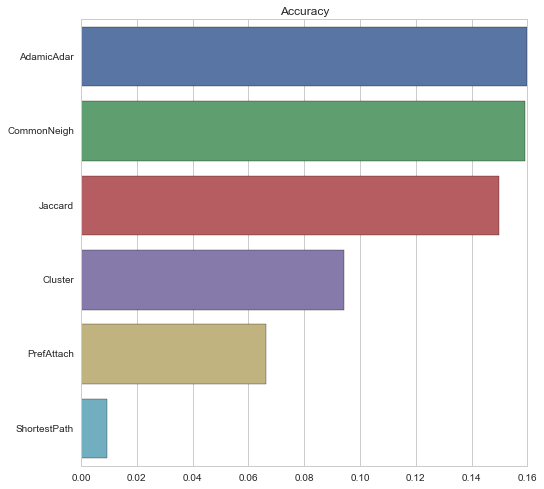

In [70]:
plt.figure(figsize = (8, 8))
sns.barplot(x = ScoringAccur, y = ScoringFunc)
plt.title('Accuracy')

Adamic/Adar and number of common neighbors are the best scoring functions among others.

**ROC and AUC**.

Add true labels for potential links.

In [81]:
TrueLabels = []
for link in df.link.values:
    if link not in NewLinks and (link[1], link[0]) not in NewLinks:
        TrueLabels.append(0); continue
    TrueLabels.append(1)
df['TrueLabels'] = TrueLabels

Function to compute components of ROC curve.

In [153]:
def CalcROCValues(scoring_func, n):
    scoring_values = df[scoring_func]
    scoring_range = np.linspace(scoring_values.min(), scoring_values.max(), n)
    scoring_range = scoring_range[::-1]
    tpr_range = []
    fpr_range = []
    PredLabels = np.zeros(df.shape[0])
    for treshold in scoring_range:
        PredLabels[(df[scoring_func] >= treshold).values] = 1
        cm = confusion_matrix(TrueLabels, PredLabels)
        tpr = recall_score(TrueLabels, PredLabels)
        fpr = cm[0][1] / sum(cm[0])
        tpr_range.append(tpr)
        fpr_range.append(fpr)
    auc_score = auc(fpr_range, tpr_range)
    return tpr_range, fpr_range, auc_score

Plot results.

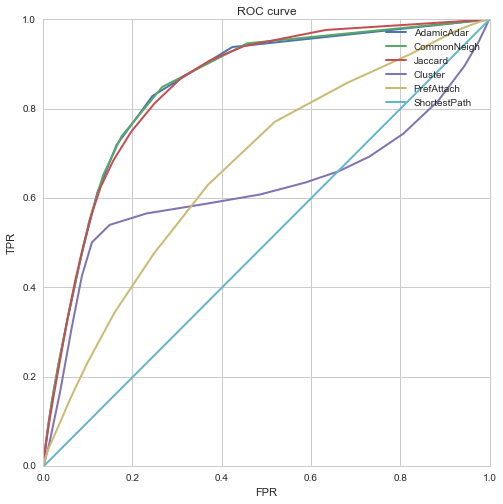

In [163]:
plt.figure(figsize = (8, 8))

tpr_ad, fpr_ad, auc_ad = CalcROCValues('AdamicAdar', 30)
tpr_cn, fpr_cn, auc_cn = CalcROCValues('CommonNeigh', 30)
tpr_jac, fpr_jac, auc_jac = CalcROCValues('Jaccard', 30)
tpr_cl, fpr_cl, auc_cl = CalcROCValues('Cluster', 30)
tpr_pr, fpr_pr, auc_pr = CalcROCValues('PrefAttach', 30)
tpr_sp, fpr_sp, auc_sp = CalcROCValues('ShortestPath', 30)

plt.plot(fpr_ad, tpr_ad, lw = 2)
plt.plot(fpr_cn, tpr_cn, lw = 2)
plt.plot(fpr_jac, tpr_jac, lw = 2)
plt.plot(fpr_cl, tpr_cl, lw = 2)
plt.plot(fpr_pr, tpr_pr, lw = 2)
plt.plot(fpr_sp, tpr_sp, lw = 2)

plt.legend(ScoringFunc)
plt.title('ROC curve'); plt.xlabel('FPR'); plt.ylabel('TPR')

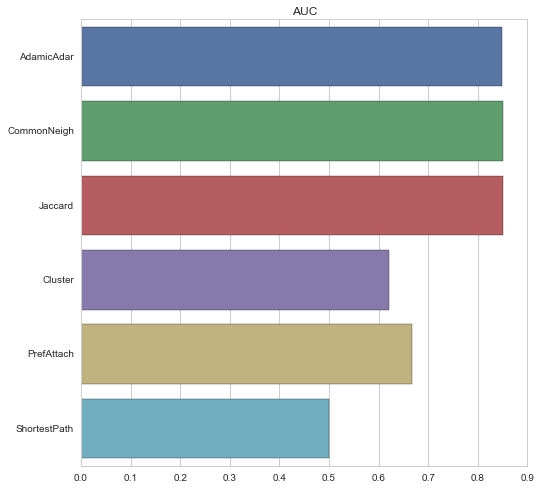

In [164]:
plt.figure(figsize = (8, 8))
sns.barplot(x = [auc_ad, auc_cn, auc_jac, auc_cl, auc_pr, auc_sp], y = ScoringFunc)
plt.title('AUC')

* Shortest path is no better then random guess for this dataset.
* Jaccard, Adamic/Adar and CommonNeighbors scoring functions are the best ones in terms of ROC/AUC